# Site Search Performance Analysis

## What's about this analysis

Site search is an important referrer to Docs content. Product & Design team keeps investing on this feature to help customers discover more content efficiently and drive better content engagement. In this analysis, we will look at the performance of site search. We will have the data of site search actions like impressions, clicks. But we will focus more on the performance - **how the page views from site search performed**. We will leverage content performance model on measuring this.

## Data to use

To be able to do this analysis, we shall have a data view of the page views from site search (we call target page views). I created functions at DevRelWorkArea Kusto database in cgadataout cluster to output that data view. To make the queries in the analysis look more readable, we use the data view instead of every time repeating the logic of getting target page views. Following is the functions used in this analysis.

* **SearchImpressionsOfSiteSearch** - Returns search impression page views with search information like search term, search results page index and so on.
* **PageViewsFromSiteSearch** - Return the page views driven by search result clicks.

*Please note:*

* We only look at en-us page views from site search because about 65% searches happen on en-us.
* MS internal traffic is excluded because we observe that the top search terms from MS internal traffic look more like test/spam.

## Initialize Kusto connection in Python Environment

Running the queries in this analysis requires package [Kqlmagic](https://github.com/microsoft/jupyter-Kqlmagic). Following commands will install and load the pacage. There's a Kusto connection creation and test command. When you run the command, you will see a link of https://microsoft.com/devicelogin popped up in the output. Please do click that and input the code. This will grant Kusto permission to your environment of this jupyter note. If you run all the commands in one session, you just have to authorize once.

In [2]:
%load_ext Kqlmagic

The Kqlmagic extension is already loaded. To reload it, use:
  %reload_ext Kqlmagic


In [ ]:
!pip install Kqlmagic --no-cache-dir --upgrade

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from azure.kusto.data.request import KustoClient, KustoConnectionStringBuilder
kcsb = KustoConnectionStringBuilder.with_aad_device_authentication("https://cgadataout.kusto.windows.net")
kc = KustoClient(kcsb)

query= """print 'OK'"""
response = kc.execute("DevRelWorkArea", query)
print(response.primary_results[0][0])

## Page Views Traffic From Site Search

First, we want to see how many topics have been visited from site search. We know that almost all non-archived live topics have been indexed into site search engine. How many of them have been reached from site search? Let's take a look at the number of January 2020.

In [8]:
# search impressions
query= """database('DevRelWorkArea').SearchImpressionsOfSiteSearch(datetime(2019-01-01),endofmonth(datetime(2020-01-01)),'en-us')
| summarize SearchImpressions = dcount(SearchPageViewId, 2) by Month = startofmonth(SearchStartDateTime)
| sort by Month asc"""
response = kc.execute("DevRelWorkArea", query)
months1 = []
impressions = []
for row in response.primary_results[0]:
    months1.append(row[0].strftime("%b %Y"))
    impressions.append(row[1])

# pages and page views from site search
query= """database("DevRelWorkArea").PageViewsFromSiteSearch(datetime(2019-01-01),endofmonth(datetime(2020-01-01)),'en-us')
| summarize topics = dcount(TargetTopicKey,2), pageviews = dcount(TargetPageViewId, 2) by Month = startofmonth(TargetStartTime)
| sort by Month asc"""
response = kc.execute("DevRelWorkArea", query)
months2 = []
pages = []
pageviews = []
for row in response.primary_results[0]:
    months2.append(row[0].strftime("%b %Y"))
    pages.append(row[1])
    pageviews.append(row[2])

print("traffic data loaded")

traffic data loaded


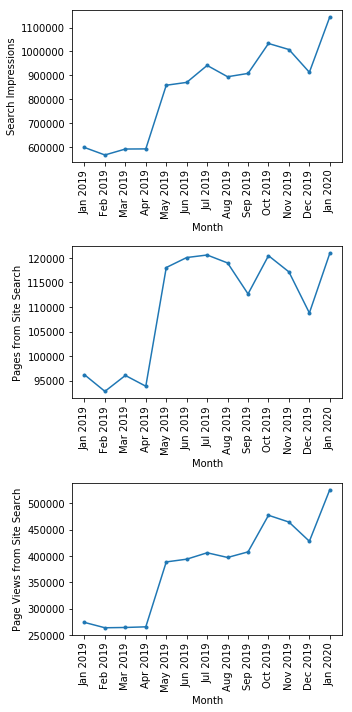

In [9]:
plt.rcParams['figure.figsize'] = [5, 10]

plt.subplot(3, 1, 1)
plt.plot(months1, impressions, '.-')
plt.xlabel('Month')
plt.ylabel('Search Impressions')
plt.xticks(rotation=90)

plt.subplot(3, 1, 2)
plt.plot(months2, pages, '.-')
plt.xlabel('Month')
plt.ylabel('Pages from Site Search')
plt.xticks(rotation=90)

plt.subplot(3, 1, 3)
plt.plot(months2, pageviews, '.-')
plt.xlabel('Month')
plt.ylabel('Page Views from Site Search')
plt.xticks(rotation=90)

plt.tight_layout()

The trend of traffic from site search shows a good growing momentum with **3 major rising points: May 2019, Oct 2019, and Jan 2020**. But we may think of another potential reason: did Docs overall traffic grow and bring more traffic to site search? Let's look at Docs overall page views traffic.

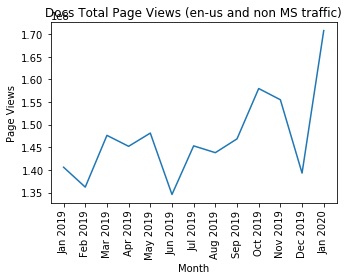

In [39]:
plt.rcParams['figure.figsize'] = [5, 4]

# Docs page views total
names = []
values = []
query= """let startDate = datetime(2019-01-01);
let endDate = endofmonth(datetime(2020-01-01));
database('CustomerTouchPoint').PageView
| where StartDateTime between (startDate..endDate)
| where Site == "docs.microsoft.com"
| where IsMSInternalTraffic != 1
| where IsTest != 1 and enrich_url_pg_query_string !contains "traffic-source=cats" 
| invoke cluster('Cgadataout').database('Publish').ApplyTechSitesBotFilters()
| where Locale == "en-us"
| summarize pageviews = dcount(PageViewId) by Month = startofmonth(StartDateTime)
| sort by Month asc"""
response = kc.execute("DevRelWorkArea", query)
for row in response.primary_results[0]:
    names.append(row[0].strftime("%b %Y"))
    values.append(row[1])
plt.plot(names,values)
plt.xlabel('Month')
plt.ylabel('Page Views')
plt.title('Docs Total Page Views (en-us and non MS traffic)')
plt.xticks(rotation=90)
plt.tight_layout()

By comparing the yoy charts of site search traffic and Docs total page views traffic, we observe that site search growth at Oct 2019 and Jan 2020 could be partly driven by the overall Docs traffic. May 2019's growth for site search should be mainly benefited from site search feature improvement. The boost could be driven by **auto suggestion** feature which is released at early of May.

## Site Search Measurements

We have seen that impressions, pages clicked from site search, and page views from site search are growing in the past year, especially from May 2019. Let's take a look the key measurements (CTR, Search Successful Rate) of site search.

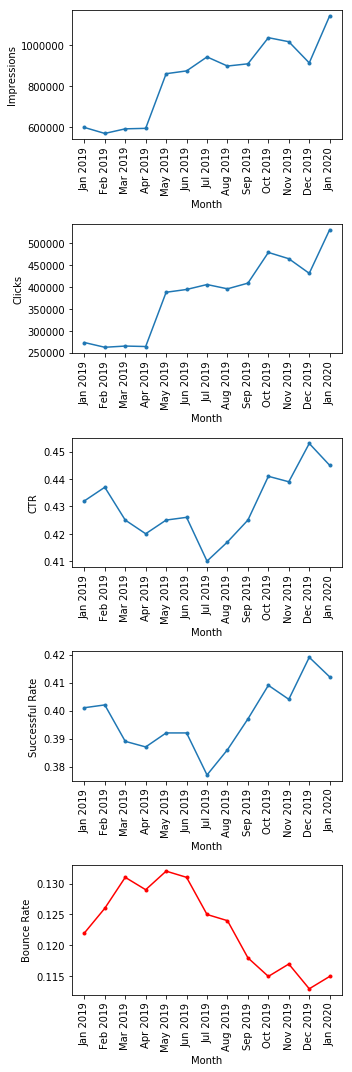

In [11]:
# yoy search impressions, page views from search, CTR, successful search rate, bounce rate of page views from search
query= """let startDate = datetime(2019-01-01);
let endDate = datetime(2020-02-01);
let locale = "en-us";
database('DevRelWorkArea').PageViewsFromSiteSearch(startDate, endofday(startofday(endDate,-1)), locale)
| summarize 
    AllResultClicks_v2 = dcount(strcat(SearchPageViewId, LinkTitle, ClickDateTime), 4),
    PageViewsFromSearch = dcount(TargetPageViewId, 4),
    NonBouncePageViewsFromSearch = dcountif(TargetPageViewId, TargetPageViewLength > 5, 4),
    MedianPageViewLength = percentiles(TargetPageViewLength, 50),
    MedianScrollPercent = percentiles(TargetMaxScroll, 50)
    by Month = startofmonth(TargetStartTime)
| join (
    database('DevRelWorkArea').SearchImpressionsOfSiteSearch(startDate, endofday(startofday(endDate,-1)), locale)
    | summarize   
        SearchImpressions = dcount(SearchPageViewId, 4),  
        UniqueVistors = dcount(SearchVisitorId, 4), 
        SearchPVwithResultClick = dcountif(SearchPageViewId, LinkTitle startswith "searchItem.", 4),
        AllResultclicks = dcountif(strcat(SearchPageViewId, LinkTitle, ClickDateTime), LinkTitle startswith "searchItem.", 4),
        UniqueSessions = dcount(SearchSessionId, 4),
        percentiles(TimetoClick, 50, 95), 
        percentiles(ResultPosition, 50, 99)  
    by Month = startofmonth(SearchStartDateTime)
    | extend AllClicksCTR = round(AllResultclicks / todouble(SearchImpressions), 3)
    | extend CTR = round(SearchPVwithResultClick / todouble(SearchImpressions), 3)
) on Month
| extend SuccessfulSearchRate = round((NonBouncePageViewsFromSearch / todouble(SearchImpressions)), 3)
| extend BounceRate = round((1 - NonBouncePageViewsFromSearch / todouble(PageViewsFromSearch)), 3)
| project Month, SearchImpressions, PageViewsFromSearch, CTR, SuccessfulSearchRate, BounceRate
| sort by Month asc"""
response = kc.execute("DevRelWorkArea", query)
months = []
impressions = []
clicks = []
ctrs = []
successrates = []
bouncerates = []
for row in response.primary_results[0]:
    months.append(row[0].strftime("%b %Y"))
    impressions.append(row[1])
    clicks.append(row[2])
    ctrs.append(row[3])
    successrates.append(row[4])
    bouncerates.append(row[5])

x = np.array(months)
y1 = np.array(impressions)
y2 = np.array(clicks)
y3 = np.array(ctrs)
y4 = np.array(successrates)
y5 = np.array(bouncerates)

plt.rcParams['figure.figsize'] = [5, 15]

plt.subplot(5, 1, 1)
plt.plot(x, y1, '.-')
plt.xlabel('Month')
plt.ylabel('Impressions')
plt.xticks(rotation=90)

plt.subplot(5, 1, 2)
plt.plot(x, y2, '.-')
plt.xlabel('Month')
plt.ylabel('Clicks')
plt.xticks(rotation=90)

plt.subplot(5, 1, 3)
plt.plot(x, y3, '.-')
plt.xlabel('Month')
plt.ylabel('CTR')
plt.xticks(rotation=90)

plt.subplot(5, 1, 4)
plt.plot(x, y4, '.-')
plt.xlabel('Month')
plt.ylabel('Successful Rate')
plt.xticks(rotation=90)

plt.subplot(5, 1, 5)
plt.plot(x, y5, 'r.-')
plt.xlabel('Month')
plt.ylabel('Bounce Rate')
plt.xticks(rotation=90)

plt.tight_layout()

We see that CTR and Successful Rate both increased from July 2019. Bounce rate decreased from July 2019. Since late of August, site search runs experiments, and let's look at how CTR and Successful Rate look between **Treatment vs. Control** groups.

In [38]:
# Treatment and Control
query= """let startDate = datetime(2019-09-01);
let endDate = datetime(2020-02-01);
let locale = "en-us";
database('DevRelWorkArea').PageViewsFromSiteSearch(startDate, endofday(startofday(endDate,-1)), locale)
| extend IsTreatment = isnotempty(SearchExperimentEventJson) and SearchExperimentEventJson contains "a9c8ddcb-77ef-4f" and SearchExperimentEventJson.experimental == "true"
| summarize
    PageViewsFromSearch_T = dcountif(TargetPageViewId, IsTreatment, 4),
    NonBouncePageViewsFromSearch_T = dcountif(TargetPageViewId, IsTreatment and TargetPageViewLength > 5, 4),
    PageViewsFromSearch_C = dcountif(TargetPageViewId, not(IsTreatment), 4),
    NonBouncePageViewsFromSearch_C = dcountif(TargetPageViewId, not(IsTreatment) and TargetPageViewLength > 5, 4)
    by Month = startofmonth(TargetStartTime)    
| join kind=rightouter (
    database('DevRelWorkArea').SearchImpressionsOfSiteSearch(startDate, endofday(startofday(endDate,-1)), locale)
    | extend IsTreatment = isnotempty(SearchExperimentEventJson) and SearchExperimentEventJson contains "a9c8ddcb-77ef-4f" and SearchExperimentEventJson.experimental == "true"
    | summarize   
        SearchImpressions_T = dcountif(SearchPageViewId, IsTreatment, 4),
        SearchImpressions_C = dcountif(SearchPageViewId, not(IsTreatment), 4), 
        SearchPVwithResultClick_T = dcountif(SearchPageViewId, IsTreatment and LinkTitle startswith "searchItem.", 4),
        SearchPVwithResultClick_C = dcountif(SearchPageViewId, not(IsTreatment) and LinkTitle startswith "searchItem.", 4)
    by Month = startofmonth(SearchStartDateTime)
    | extend CTR_T = round(SearchPVwithResultClick_T / todouble(SearchImpressions_T), 3)
    | extend CTR_C = round(SearchPVwithResultClick_C / todouble(SearchImpressions_C), 3)
) on Month
| extend SuccessfulSearchRate_T = round((NonBouncePageViewsFromSearch_T / todouble(SearchImpressions_T)), 3)
| extend SuccessfulSearchRate_C = round((NonBouncePageViewsFromSearch_C / todouble(SearchImpressions_C)), 3)
| extend BounceRate_T = round((1 - NonBouncePageViewsFromSearch_T / todouble(PageViewsFromSearch_T)), 3)
| extend BounceRate_C = round((1 - NonBouncePageViewsFromSearch_C / todouble(PageViewsFromSearch_C)), 3)
| project Month,
    PageViewsFromSearch_T,
    PageViewsFromSearch_C,
    CTR_T,
    CTR_C,
    SuccessfulSearchRate_T,
    SuccessfulSearchRate_C,
    BounceRate_T,
    BounceRate_C
| sort by Month asc"""
response = kc.execute("DevRelWorkArea", query)
month = []
pv_t = []
pv_c = []
ctr_t = []
ctr_c = []
successrate_t = []
successrate_c = []
bouncerate_t = []
bouncerate_c = []
for row in response.primary_results[0]:
    month.append(row[0].strftime("%b %Y"))
    pv_t.append(row[1])
    pv_c.append(row[2])
    ctr_t.append(row[3])
    ctr_c.append(row[4])
    successrate_t.append(row[5])
    successrate_c.append(row[6])
    bouncerate_t.append(row[7])
    bouncerate_c.append(row[8])

print("Treatment and Control data loaded")

Treatment and Control data loaded


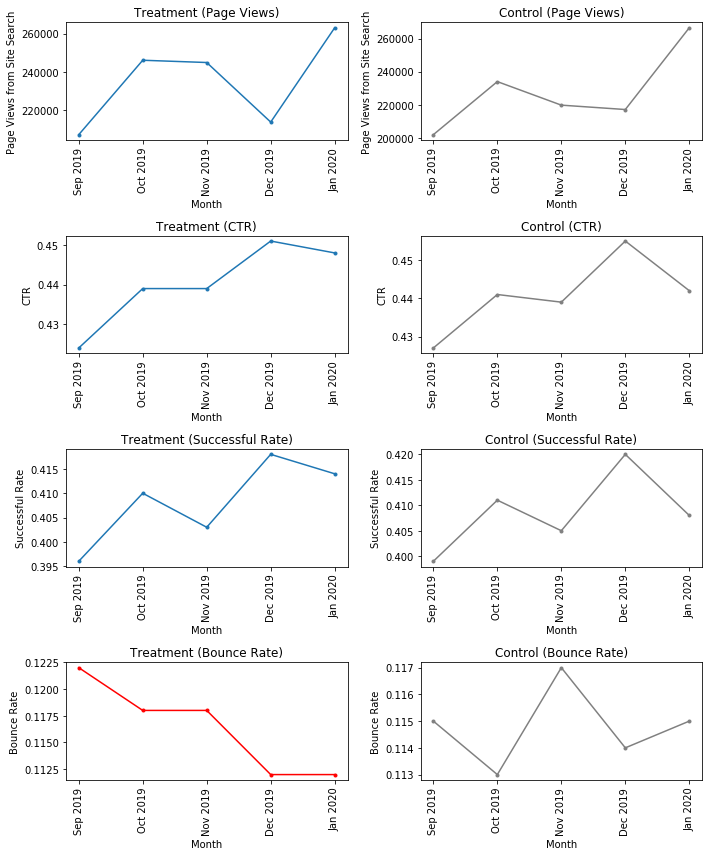

In [40]:
# ctr_t_f = np.array(ctr_t)
# ctr_t_f = np.where(ctr_t_f<0,0,ctr_t_f)

plt.rcParams['figure.figsize'] = [10, 12]

plt.subplot(4, 2, 1)
plt.plot(month, pv_t, '.-')
plt.xlabel('Month')
plt.ylabel('Page Views from Site Search')
plt.title('Treatment (Page Views)')
plt.xticks(rotation=90)

plt.subplot(4, 2, 2)
plt.plot(month, pv_c, '.-', c='grey')
plt.xlabel('Month')
plt.ylabel('Page Views from Site Search')
plt.title('Control (Page Views)')
plt.xticks(rotation=90)

plt.subplot(4, 2, 3)
plt.plot(month, ctr_t, '.-')
plt.xlabel('Month')
plt.ylabel('CTR')
plt.title('Treatment (CTR)')
plt.xticks(rotation=90)

plt.subplot(4, 2, 4)
plt.plot(month, ctr_c, '.-', c='grey')
plt.xlabel('Month')
plt.ylabel('CTR')
plt.title('Control (CTR)')
plt.xticks(rotation=90)

plt.subplot(4, 2, 5)
plt.plot(month, successrate_t, '.-')
plt.xlabel('Month')
plt.ylabel('Successful Rate')
plt.title('Treatment (Successful Rate)')
plt.xticks(rotation=90)

plt.subplot(4, 2, 6)
plt.plot(month, successrate_c, '.-', c='grey')
plt.xlabel('Month')
plt.ylabel('Successful Rate')
plt.title('Control (Successful Rate)')
plt.xticks(rotation=90)

plt.subplot(4, 2, 7)
plt.plot(month, bouncerate_t, '.-', c='r')
plt.xlabel('Month')
plt.ylabel('Bounce Rate')
plt.title('Treatment (Bounce Rate)')
plt.xticks(rotation=90)

plt.subplot(4, 2, 8)
plt.plot(month, bouncerate_c, '.-', c='grey')
plt.xlabel('Month')
plt.ylabel('Bounce Rate')
plt.title('Control (Bounce Rate)')
plt.xticks(rotation=90)

plt.tight_layout()

Briefly, Treatment and Control groups have similar trend. In different months, they perform differently.

In December 2019, Control group performed a little bit better:

    * Control - CTR: 45.5%, Successful Rate: 42.0%
    * Treatment - CTR: 45.1%, Successful Rate: 41.8%

But in January 2020, Treatment group performed better:

    * Control - CTR: 44.2%, Successful Rate: 40.8%
    * Treatment - CTR: 44.8%, Successful Rate: 41.4%

## Page View Performance From Site Search 

We have seen that search impressions volume is growing up. There are more and more page views happended from clicking the search results via site search. We also observed that the successful search rate is going up and bounce rate is going down. But there are different types of content clicked from site search. Bounce rate is one of the measurements. However, there are other important measurements for different type of content (like DwellTime, ClickThroughRate, etc.). By leveraging content performance measurement approach, we can deep dive into the performance of different types and pages from site search.

Let's take a look what are the different types of content clicked from site search.

In [2]:
# page views from site search breakdown by page type
query= """let startDate = datetime(2019-01-01);
let endDate = datetime(2020-02-01);
let locale = "en-us";
database('DevRelWorkArea').PageViewsFromSiteSearch(startDate, endofday(startofday(endDate,-1)), locale)
| join kind=inner (
database('DevRelWorkArea').GetTopics(locale)
) on $left.TargetTopicKey == $right.TopicKey
| summarize 
    PageViewsFromSearch = dcount(TargetPageViewId, 4) by Month = startofmonth(TargetStartTime), PageType
| project Month, PageType, PageViewsFromSearch
| sort by Month asc, PageType asc"""
response = kc.execute("DevRelWorkArea", query)    
month = []
ptype = []
pv = []
for row in response.primary_results[0]:
    month.append(row[0])
    ptype.append(row[1])
    pv.append(row[2])
print('page views from site search by page type loaded')

page views from site search by page type loaded


Text(0.5, 1.0, 'Page Views From Site Search by Page Type')

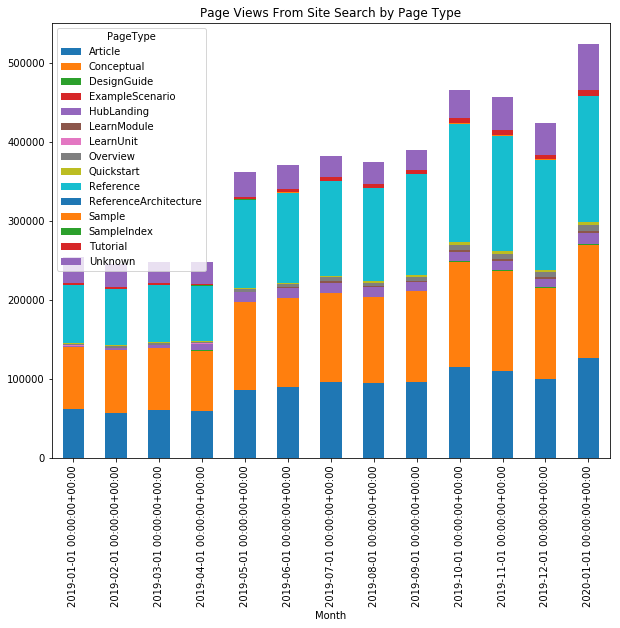

In [3]:
df = pd.DataFrame({"Month": month,
                  "PageType": ptype,
                  "PageViewsFromSearch": pv})
tdf = df.groupby(['Month','PageType'])['PageViewsFromSearch'].sum().unstack('PageType')
plt.rcParams['figure.figsize'] = [10, 8]
tdf.plot(kind='bar', stacked=True)
plt.title("Page Views From Site Search by Page Type")

Then let's see the performance of those page views. The content performance approach measures each topic and gives a performance score by using different metrics according to different page type. Please refer to [how **PrimaryKPIScore** is calculated](https://review.docs.microsoft.com/en-us/help/contribute/primarykpiscore-metric?branch=master). PrimaryKPIScore is calculated based all the page views happened on certain topic page. But we here focus on the page views from Site Search. So, we narrow down to the page views from site search and apply the same peformance score calculation formula by different page types. To distinush from the PrimaryKPIScore used in content performance report, we define the PrimaryKPIScore of a topic based on the overall traffic is level 1, and we say <font color='blue'>PrimaryKPIScoreL1</font>. We define the PrimaryKPIScore of a topic based on site search traffic is level 2, and we say <font color='blue'>PrimaryKPIScoreL2</font>.

So, if <font color='blue'>PrimaryKPIScoreL2 > PrimaryKPIScoreL1</font>, we may consider the performance of the traffic from site search on certain topic page is relatively better than the overall traffic on that topic. Furthermore, within one page type, we can get median value of the PrimaryKPIScoreL2. If that median value is higher than the median value of PrimaryKPIScoreL1, we may consider that site search traffic on this page type is relatively better against the overall traffic on the certain page type.

Let's take a look at the median of PrimaryKPIScoreL2 vs. the median of PrimaryKPIScoreL1 of January 2020, by page type. We exclude LearnModule and LearnUnit because site search only index learning paths and modules' index pages. Content performance KPI for LearnModule and LearnUnit are based on module completion and unit completion. It's unfair to measure the module/unit completion directly referred from site search when users can only land on the index page from site search.

In [18]:
# get PrimaryKPIScoreL2 and PrimaryKPIScoreL1 by page type
query= """let startDate = datetime(2020-01-01);
let endDate = datetime(2020-02-01);
let locale = "en-us";
database('DevRelWorkArea').PageViewsFromSiteSearch(startDate, endofday(startofday(endDate,-1)), locale)
| join kind=leftouter (
cluster('cgadataout').database('CustomerTouchPoint').PageView
| where StartDateTime >= startDate and StartDateTime < endDate
| where Site == "docs.microsoft.com"
| where Locale == locale
| where IsTest!=1 and enrich_url_pg_query_string !contains "traffic-source=cats" | invoke cluster('Cgadataout').database('DevRelWorkArea').ApplyTechSitesBotFilters()
| summarize hint.strategy = shuffle (StartDateTime, PageViewId, Url, TopicKey, ReferrerType, ReferrerDomain, Referrer_uri_stem, ReferrerQueryString) = arg_max(StartDateTime, PageViewId, Url, TopicKey, ReferrerType, ReferrerDomain, Referrer_uri_stem, ReferrerQueryString) by enrich_session_id
| extend ReferrerUrl = strcat("https://",ReferrerDomain,Referrer_uri_stem) //SiteSearch
| where not(Url matches regex "https://docs.microsoft.com/([^/]*)/search/") //SiteSearch
| where ReferrerUrl matches regex "https://docs.microsoft.com/([^/]*)/search/" //SiteSearch
| project TargetPageViewId = PageViewId, IsExit = 1
) on TargetPageViewId
| summarize hint.strategy = shuffle
    Pages = dcount(TargetTopicKey,2),
    PageViews = dcount(TargetPageViewId,2),
    Bounces=dcountif(TargetPageViewId, TargetIsBounce, 2),
    ClickThroughs = dcountif(TargetPageViewId, TargetLinkClickEvents>0, 2),
    Exits = dcountif(TargetPageViewId, IsExit==1, 2),
    MedianPageViewTime = percentile(TargetPageViewLength,50)
    by TargetTopicKey
| join kind=inner (
database("DevRelWorkArea").GetTopics(locale)
) on $left.TargetTopicKey == $right.TopicKey
| where PageType !in ('LearnModule','LearnUnit')
| extend
    BounceRate = Bounces/todouble(PageViews),
    ClickThroughRate = ClickThroughs/todouble(PageViews),
    DwellTimeDelta = (MedianPageViewTime - EstimatedSecondsToRead)/todouble(EstimatedSecondsToRead),
    ExitRate = Exits/todouble(PageViews),
    LearnModuleCompletion = 0,
    LearnUnitCompletion = 0,
    LearnModuleCompletionRate = 0.0,
    LearnUnitCompletionRate = 0.0
| invoke cluster('cgadataout.kusto.windows.net').database('Publish').GetPrimaryKPIScore()
| extend PrimaryKPIScoreL2 = PrimaryKPIScore
| summarize
    Pages = sum(Pages),
    PageViews = sum(PageViews),
    (25PercentilePrimaryKPIScoreL2, MedianPrimaryKPIScoreL2) = percentiles(PrimaryKPIScoreL2, 25, 50)
    by PageType
| join kind=leftouter (
database("DevRelWorkArea").GetL1PrimaryKPIScore(startDate, "en-us")
) on PageType
| project PageType, MedianPrimaryKPIScoreL2, 25PercentilePrimaryKPIScoreL2, MedianPrimaryKPIScoreL1 = MedianPrimaryKPIScore_L1, 25PercentilePrimaryKPIScoreL1 = ThresholdPrimaryKPIScore_L1
| sort by PageType asc"""
response = kc.execute("DevRelWorkArea", query)
ptype = []
mL2 = []
oL2 = []
mL1 = []
oL1 = []
for row in response.primary_results[0]:
    ptype.append(row[0])
    mL2.append(row[1])
    oL2.append(row[2])
    mL1.append(row[3])
    oL1.append(row[4])
print(ptype)

['Article', 'Conceptual', 'DesignGuide', 'ExampleScenario', 'HubLanding', 'Overview', 'Quickstart', 'Reference', 'ReferenceArchitecture', 'Sample', 'SampleIndex', 'Tutorial', 'Unknown']


                 PageType  MedianPrimaryKPIScoreL2  MedianPrimaryKPIScoreL1
0   Article               -0.483237                -0.604816               
1   Conceptual            -0.491415                -0.623145               
2   DesignGuide            0.476190                 0.325834               
3   ExampleScenario        0.500000                 0.305040               
4   HubLanding             1.000000                 0.728057               
5   Overview              -0.431408                -0.562792               
6   Quickstart             0.333333                 0.286061               
7   Reference              0.311226                 0.200021               
8   ReferenceArchitecture  0.326667                 0.363636               
9   Sample                 0.333333                 0.229293               
10  SampleIndex            0.928571                 0.809586               
11  Tutorial               0.298121                 0.193698               
12  Unknown 

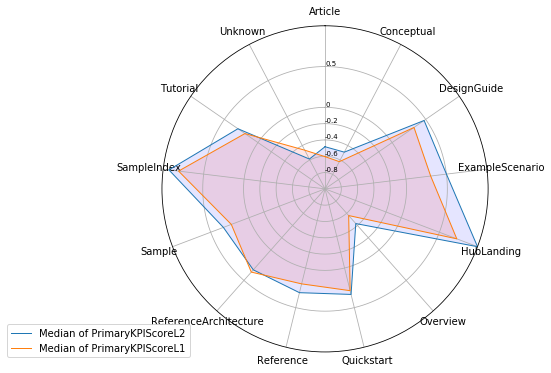

In [19]:
df = pd.DataFrame({"PageType": ptype,
                  "MedianPrimaryKPIScoreL2": mL2,
                  "MedianPrimaryKPIScoreL1": mL1})
print(df)
df = df.T
df.columns = df.iloc[0]
df = df.iloc[1:]
df = df.reset_index()

plt.rcParams['figure.figsize'] = [8, 6]

## Radar Chart
from math import pi

# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([-0.8,-0.6,-0.4,-0.2,0,0.5], ["-0.8","-0.6","-0.4","-0.2","0","0.5"], color="black", size=7)
plt.ylim(-1,1)
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.loc[0].drop('index').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Median of PrimaryKPIScoreL2")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('index').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Median of PrimaryKPIScoreL1")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()

We see that most of the page types have the median value of PrimaryKPIScoreL2 (performance from site search) better than the median value of PrimaryKPIScoreL1 (performance overall) except "ReferenceArchitecture" and "Unknown" types. There have another important concept **25 Percentile of PrimaryKPIScore** in content performance model which is used for identifying overperforming topics vs underperformance topics. Let's see how the radar chart becomes when comparing the 25 percentile values between PrimaryKPIScoreL2 and PrimaryKPIScoreL1.

                 PageType  25PctlPrimaryKPIScoreL2  25PctlPrimaryKPIScoreL1
0                 Article                -0.872646                -0.806618
1              Conceptual                -0.865836                -0.827251
2             DesignGuide                 0.250000                 0.228661
3         ExampleScenario                 0.250000                 0.255981
4              HubLanding                 0.600000                 0.449210
5                Overview                -0.698518                -0.677644
6              Quickstart                 0.000000                 0.187361
7               Reference                 0.000000                 0.000000
8   ReferenceArchitecture                 0.000000                 0.264394
9                  Sample                 0.000000                 0.081527
10            SampleIndex                 0.000000                 0.496154
11               Tutorial                 0.000000                 0.026564
12          

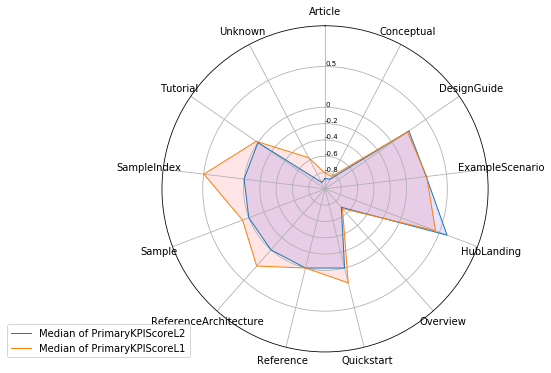

In [6]:
df = pd.DataFrame({"PageType": ptype,
                  "25PctlPrimaryKPIScoreL2": oL2,
                  "25PctlPrimaryKPIScoreL1": oL1})
print(df)
df = df.T
df.columns = df.iloc[0]
df = df.iloc[1:]
df = df.reset_index()

## Radar Chart
from math import pi

# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([-0.8,-0.6,-0.4,-0.2,0,0.5], ["-0.8","-0.6","-0.4","-0.2","0","0.5"], color="black", size=7)
plt.ylim(-1,1)

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.loc[0].drop('index').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Median of PrimaryKPIScoreL2")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('index').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Median of PrimaryKPIScoreL1")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()

It is interesting that the 25 percentile chart shows a different result. Most of the page types have the 25 percentile values of PrimaryKPIScoreL1 are larger than what of L2. Putting median value comparison and 25 percentile value comparison together, an hypothesis is that the PrimaryKPIScoreL2 values are not normally distributed. Let's look at the PrimaryKPIScoreL2 scores distribution of "Article" type.

In [7]:
# get PrimaryKPIScoreL2 by topics from site search
query= """let startDate = datetime(2020-01-01);
let endDate = datetime(2020-02-01);
let locale = "en-us";
database('DevRelWorkArea').PageViewsFromSiteSearch(startDate, endofday(startofday(endDate,-1)), locale)
| join kind=leftouter (
cluster('cgadataout').database('CustomerTouchPoint').PageView
| where StartDateTime >= startDate and StartDateTime < endDate
| where Site == "docs.microsoft.com"
| where Locale == locale
| where IsTest!=1 and enrich_url_pg_query_string !contains "traffic-source=cats" | invoke cluster('Cgadataout').database('DevRelWorkArea').ApplyTechSitesBotFilters()
| summarize hint.strategy = shuffle (StartDateTime, PageViewId, Url, TopicKey, ReferrerType, ReferrerDomain, Referrer_uri_stem, ReferrerQueryString) = arg_max(StartDateTime, PageViewId, Url, TopicKey, ReferrerType, ReferrerDomain, Referrer_uri_stem, ReferrerQueryString) by enrich_session_id
| extend ReferrerUrl = strcat("https://",ReferrerDomain,Referrer_uri_stem) //SiteSearch
| where not(Url matches regex "https://docs.microsoft.com/([^/]*)/search/") //SiteSearch
| where ReferrerUrl matches regex "https://docs.microsoft.com/([^/]*)/search/" //SiteSearch
| project TargetPageViewId = PageViewId, IsExit = 1
) on TargetPageViewId
| summarize hint.strategy = shuffle
    Pages = dcount(TargetTopicKey,2),
    PageViews = dcount(TargetPageViewId,2),
    Bounces=dcountif(TargetPageViewId, TargetIsBounce, 2),
    ClickThroughs = dcountif(TargetPageViewId, TargetLinkClickEvents>0, 2),
    Exits = dcountif(TargetPageViewId, IsExit==1, 2),
    MedianPageViewTime = percentile(TargetPageViewLength,50)
    by TargetTopicKey
| join kind=inner (
database("DevRelWorkArea").GetTopics(locale)
) on $left.TargetTopicKey == $right.TopicKey
| where PageType == 'Article'
| extend
    BounceRate = Bounces/todouble(PageViews),
    ClickThroughRate = ClickThroughs/todouble(PageViews),
    DwellTimeDelta = (MedianPageViewTime - EstimatedSecondsToRead)/todouble(EstimatedSecondsToRead),
    ExitRate = Exits/todouble(PageViews),
    LearnModuleCompletion = 0,
    LearnUnitCompletion = 0,
    LearnModuleCompletionRate = 0.0,
    LearnUnitCompletionRate = 0.0
| invoke cluster('cgadataout.kusto.windows.net').database('Publish').GetPrimaryKPIScore()
| extend PrimaryKPIScoreL2 = PrimaryKPIScore
| project TargetTopicKey, PrimaryKPIScoreL2, PageViews"""
response = kc.execute("DevRelWorkArea", query)
tpL2 = []
scoreL2 = []
pvL2 = []
for row in response.primary_results[0]:
    tpL2.append(row[0])
    scoreL2.append(row[1])
    pvL2.append(row[2])
print("data loaded")

data loaded


Text(0.5, 0, 'PrimaryKPIScoreL2 with outliers set to 2')

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


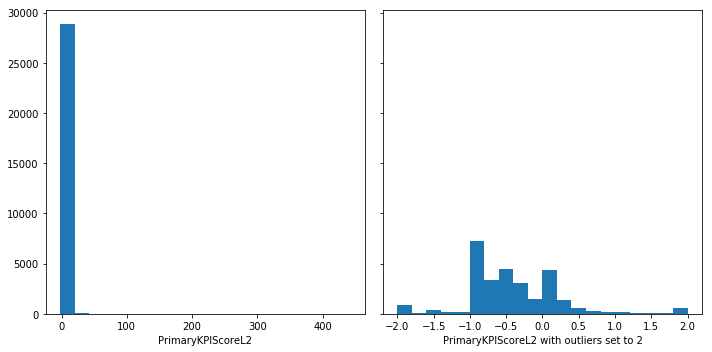

In [8]:
n_bins = 20
n_scoreL2 = []
for (i, item) in enumerate(scoreL2):
    if item > 2:
        n_scoreL2.append(2)
    else:
        n_scoreL2.append(item)

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(10,5))
axs[0].hist(scoreL2, bins=n_bins)
axs[0].set_xlabel('PrimaryKPIScoreL2')
axs[1].hist(n_scoreL2, bins=n_bins)
axs[1].set_xlabel('PrimaryKPIScoreL2 with outliers set to 2')

In the left chart, it shows the distribution of the actual PrimaryKPIScoreL2 values of Article page type. The right chart shows the distribution of PrimaryKPIScoreL2 values with outliers fixed. There are several topics (viewed from site search) having extremely large DwellTime which made the performance score be a very big value. I set the score of these outliers to 2 which can get a more readable histogram.

In [10]:
# get PrimaryKPIScoreL1 by topics
query= """database('Publish').ContentKPIByTopicKeyMonthly
| where startofmonth(Date) == datetime(2020-01-01)
| where Locale == 'en-us'
| where RepoName !contains 'office'
| where RepoName !contains 'dynamics'
| where RepoName !contains 'outlook'
| where TopicKey <>  '63846178-bbbb-de25-87cb-4d0b397ea523'
| extend TopicType = tostring(TopicType)
| invoke cluster('cgadataout.kusto.windows.net').database('Publish').GetPrimaryKPIScore()
| where PageType == 'Article'
| project TopicKey, PrimaryKPIScore, PageViews"""
response = kc.execute("DevRelWorkArea", query)
tpL1 = []
scoreL1 = []
pvL1 = []
for row in response.primary_results[0]:
    tpL1.append(row[0])
    scoreL1.append(row[1])
    pvL1.append(row[2])
print("PrimaryKPIScore (L1) loaded")

PrimaryKPIScore (L1) loaded


Text(0.5, 0, 'PrimaryKPIScoreL1 with outliers set to 2')

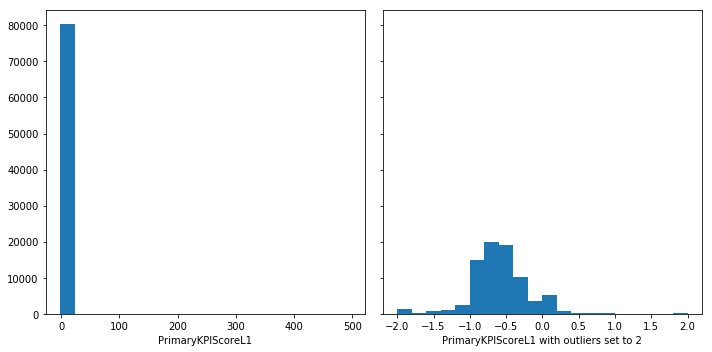

In [11]:
n_bins = 20
n_scoreL1 = []
for (i, item) in enumerate(scoreL1):
    if item > 2:
        n_scoreL1.append(2)
    else:
        n_scoreL1.append(item)
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(10,5))
axs[0].hist(scoreL1, bins=n_bins)
axs[0].set_xlabel('PrimaryKPIScoreL1')
axs[1].hist(n_scoreL1, bins=n_bins)
axs[1].set_xlabel('PrimaryKPIScoreL1 with outliers set to 2')

Looking at PrimaryKPIScoreL1 scores distribution (with outliers fixed), we see that L1 scores match the normal distribution. This probably can translate to: the performance of the page views from all referrers is more likely a normal distribution. But when people do search, depends on the relevancy between the clicked page and user's intend, it easier to drive good/bad engagement more strongly.

Let's also take a look how the page views from site search perform compare to other major content discovery channel. According to the query effort, here leverages the data aggregated by [findability dashboard](https://aka.ms/cldocsreferrerdash).

In [20]:
query= """database("DevRelWorkArea").['kpi-findability-performance']
| where Month==datetime(2020-01-01)
| where Referrer in ('Organic Search', 'Direct Traffic', 'Hub Landing')
| project Referrer, PageType, MedianPrimaryKPIScore_L2
| evaluate pivot(Referrer, avg(MedianPrimaryKPIScore_L2))
| where PageType !in ('LearnModule','LearnUnit')
| sort by PageType asc"""
response = kc.execute("DevRelWorkArea", query)
ptype_2 = []
osmL2 = []
dfmL2 = []
hbmL2 = []
for row in response.primary_results[0]:
    ptype_2.append(row[0])
    osmL2.append(row[1])
    dfmL2.append(row[2])
    hbmL2.append(row[3])
print("other referrers' performance data loaded")

other referrers' performance data loaded


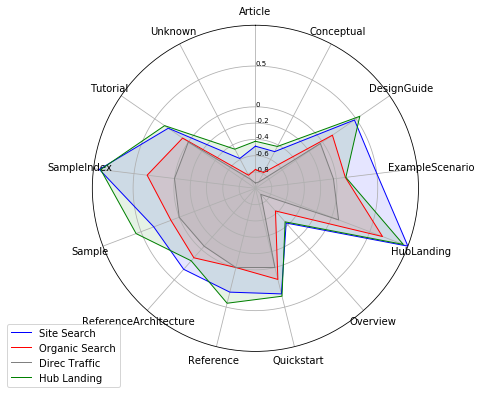

In [30]:
df = pd.DataFrame({"PageType": ptype,
                  "SiteSearch": mL2,
                  "OrganicSearch": osmL2,
                  "DirectTraffic": dfmL2,
                  "HubLanding": hbmL2})
# print(df)
df = df.T
df.columns = df.iloc[0]
df = df.iloc[1:]
df = df.reset_index()

plt.rcParams['figure.figsize'] = [8, 6]

## Radar Chart
from math import pi

# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([-0.8,-0.6,-0.4,-0.2,0,0.5], ["-0.8","-0.6","-0.4","-0.2","0","0.5"], color="black", size=7)
plt.ylim(-1,1)
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.loc[0].drop('index').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Site Search", color='b')
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('index').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Organic Search", color='r')
ax.fill(angles, values, 'r', alpha=0.1)

# Ind3
values=df.loc[2].drop('index').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Direc Traffic", color='grey')
ax.fill(angles, values, 'grey', alpha=0.1)

# Ind4
values=df.loc[3].drop('index').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Hub Landing", color='g')
ax.fill(angles, values, 'g', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()

According to the PrimaryKPIScoreL2 scores, site search has higher median value than organic search, much higher than direct traffic. Some of the types from site search have higher median values than Hub/Landing, some are lower.

Since we get idea of how PrimaryKPIScoreL2 is measured. And we have seen which page type performs relatively better on the traffic from site search. PrimaryKPIScoreL2 is calculated at topic level, to understand better how the performance score impacts, we need to combine with the volume of page view traffic.

In content performance model, we calculate % of page views on overperforming topics. The overperforming is based on the 25 percentile value of PrimaryKPIScore of within the page type. So, let's use similar idea and define: **If the PrimaryKPIScoreL2 > 25 percentile value of PrimaryKPIScoreL1, then we say the topic from site search (its traffic from site search) is high performing. Otherwise we say the topic from site search is low performing.**

Then we may the distribution of how many topics (clicked from site search) are high performing vs low performing and their page views from site search.

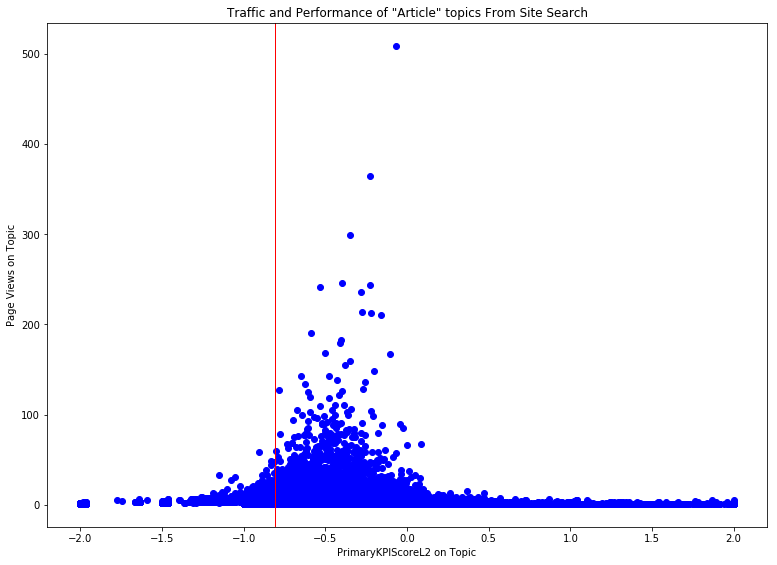

In [12]:
# reference to https://www.tutorialspoint.com/matplotlib/matplotlib_scatter_plot.htm
fig=plt.figure(figsize=(10,7))
ax=fig.add_axes([0,0,1,1])
ax.scatter(n_scoreL2, pvL2, color='b')
ax.set_xlabel('PrimaryKPIScoreL2 on Topic')
ax.set_ylabel('Page Views on Topic')
ax.set_title('Traffic and Performance of "Article" topics From Site Search')
plt.axvline(x=-0.806618064897507, color='r', linewidth=1)
plt.show()

From the scatter chart, we may see that more than 85% of the points are at right side of the red line. The red vertical line is 25 percentile value of PrimaryKPIScoreL1. The y axis is the page views on each topic. We can see most of the pages having page views less than 100. There are several pages having high traffic, all of them seems be high performing.

Furthermore, we can sum the page views of the high performing topics from site search, and we sum the page views of the low performing topics from site search. Thus, we are able to know the percentage of page views on high performing topics. Let's take a look at that percentage of site search month over month (according to the data query effort, that percentage has been pre-calcuated).

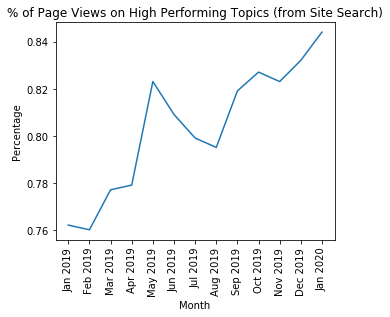

In [38]:
plt.rcParams['figure.figsize'] = [5, 4]

# percentage of page views on high performing topics
names = []
values = []
query= """['kpi-site-search-perf-pv-rate']
| where Month>= datetime(2019-01-01) and Month<=datetime(2020-01-01)
| project Month, rate_highperf
| sort by Month asc"""
response = kc.execute("DevRelWorkArea", query)
for row in response.primary_results[0]:
    names.append(row[0].strftime("%b %Y"))
    values.append(row[1])
plt.plot(names,values)
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.title('% of Page Views on High Performing Topics (from Site Search)')
plt.xticks(rotation=90)
plt.show()

From the trend, we see that the % of page views on high performing topics (from site search) had a significant increase at May 2019, and then went down during July 2019-August 2019. After that, it goes up again and keep growing in last 6 months. This pattern looks similar with the search successful rate. 

The % of page views on high performing topics can be different to different page types. Then let's have it breakdown to page type level (LearnModule, LearnUnit not included).

In [13]:
# get PrimaryKPIScoreL1 by topics
query= """let startDate = datetime(2020-01-01);
let endDate = datetime(2020-02-01);
let locale = "en-us";
database('DevRelWorkArea').PageViewsFromSiteSearch(startDate, endofday(startofday(endDate,-1)), locale)
| join kind=leftouter (
cluster('cgadataout').database('CustomerTouchPoint').PageView
| where StartDateTime >= startDate and StartDateTime < endDate
| where Site == "docs.microsoft.com"
| where Locale == locale
| where IsTest!=1 and enrich_url_pg_query_string !contains "traffic-source=cats" | invoke cluster('Cgadataout').database('DevRelWorkArea').ApplyTechSitesBotFilters()
| summarize hint.strategy = shuffle (StartDateTime, PageViewId, Url, TopicKey, ReferrerType, ReferrerDomain, Referrer_uri_stem, ReferrerQueryString) = arg_max(StartDateTime, PageViewId, Url, TopicKey, ReferrerType, ReferrerDomain, Referrer_uri_stem, ReferrerQueryString) by enrich_session_id
| extend ReferrerUrl = strcat("https://",ReferrerDomain,Referrer_uri_stem) //SiteSearch
| where not(Url matches regex "https://docs.microsoft.com/([^/]*)/search/") //SiteSearch
| where ReferrerUrl matches regex "https://docs.microsoft.com/([^/]*)/search/" //SiteSearch
| project TargetPageViewId = PageViewId, IsExit = 1
) on TargetPageViewId
| summarize hint.strategy = shuffle
    Pages = dcount(TargetTopicKey,2),
    PageViews = dcount(TargetPageViewId,2),
    Bounces=dcountif(TargetPageViewId, TargetIsBounce, 2),
    ClickThroughs = dcountif(TargetPageViewId, TargetLinkClickEvents>0, 2),
    Exits = dcountif(TargetPageViewId, IsExit==1, 2),
    MedianPageViewTime = percentile(TargetPageViewLength,50)
    by TargetTopicKey
| join kind=inner (
database("DevRelWorkArea").GetTopics(locale)
) on $left.TargetTopicKey == $right.TopicKey
| where PageType !in ('LearnModule','LearnUnit')
| extend
    BounceRate = Bounces/todouble(PageViews),
    ClickThroughRate = ClickThroughs/todouble(PageViews),
    DwellTimeDelta = (MedianPageViewTime - EstimatedSecondsToRead)/todouble(EstimatedSecondsToRead),
    ExitRate = Exits/todouble(PageViews),
    LearnModuleCompletion = 0,
    LearnUnitCompletion = 0,
    LearnModuleCompletionRate = 0.0,
    LearnUnitCompletionRate = 0.0
| invoke cluster('cgadataout.kusto.windows.net').database('Publish').GetPrimaryKPIScore()
| extend PrimaryKPIScoreL2 = PrimaryKPIScore
| project TargetTopicKey, PrimaryKPIScoreL2, PageViews, PageType
| join kind=leftouter (
database("DevRelWorkArea").GetL1PrimaryKPIScore(startDate, "en-us")
) on PageType
| summarize
    pv_highperf = sumif(PageViews, PrimaryKPIScoreL2 > ThresholdPrimaryKPIScore_L1),
    pv_lowperf = sumif(PageViews, PrimaryKPIScoreL2 <= ThresholdPrimaryKPIScore_L1)
    by PageType
| extend pv_total = pv_highperf+pv_lowperf
| extend rate_highperf = round(pv_highperf/todouble(pv_total),3)
| sort by PageType desc"""
response = kc.execute("DevRelWorkArea", query)
ptype = []
pvhighperf = []
pvlowperf = []
pvtotal = []
ratehighperf = []
for row in response.primary_results[0]:
    ptype.append(row[0])
    pvhighperf.append(row[1])
    pvlowperf.append(row[2])
    pvtotal.append(row[3])
    ratehighperf.append(row[4])
print("data loaded")

data loaded


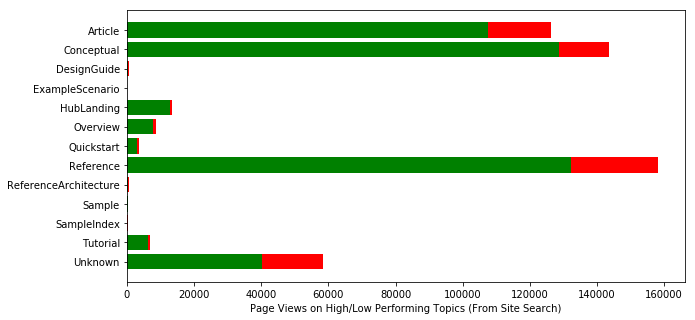

                 PageType  % of Page Views on High Performing Topics
12                Article                                      0.853
11             Conceptual                                      0.896
10            DesignGuide                                      0.903
9         ExampleScenario                                      0.769
8              HubLanding                                      0.943
7                Overview                                      0.892
6              Quickstart                                      0.801
5               Reference                                      0.836
4   ReferenceArchitecture                                      0.608
3                  Sample                                      0.787
2             SampleIndex                                      0.588
1                Tutorial                                      0.919
0                 Unknown                                      0.685


In [14]:
# reference to https://stackoverflow.com/questions/21397549/stack-bar-plot-in-matplotlib-and-add-label-to-each-section-and-suggestions
y_pos = np.arange(len(ptype))
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.barh(y_pos, pvtotal,color='r',align='center')
ax.barh(y_pos, pvhighperf,color='g',align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ptype)
ax.set_xlabel('Page Views on High/Low Performing Topics (From Site Search)')
plt.show()

df = pd.DataFrame({"PageType": ptype,
                  "% of Page Views on High Performing Topics": ratehighperf})
df = df[::-1]
print(df)

From that table, we can see "Reference", "Conceptual", "Article" types have high page views traffic. Their % of page views on high performing topics (from site search) are around 85%. "Unknown" type also has relatively high page view traffic comparing to the rest, its % is low, only 68.9%. We may have interests to see what are the low performing pages referred from site search, especially the ones having relatively high page views traffic. Following lists the top 20 low performing Reference topics from site search, ranked by their page views from site search.

In [12]:
# get PrimaryKPIScoreL2 by topics
query= """let startDate = datetime(2020-01-01);
let endDate = startofmonth(startDate,1);
let locale = "en-us";
database('DevRelWorkArea').PageViewsFromSiteSearch(startDate, endofday(startofday(endDate,-1)), locale)
| join kind=leftouter (
cluster('cgadataout').database('CustomerTouchPoint').PageView
| where StartDateTime >= startDate and StartDateTime < endDate
| where Site == "docs.microsoft.com"
| where Locale == locale
| where IsTest!=1 and enrich_url_pg_query_string !contains "traffic-source=cats" | invoke cluster('Cgadataout').database('DevRelWorkArea').ApplyTechSitesBotFilters()
| summarize hint.strategy = shuffle (StartDateTime, PageViewId, Url, TopicKey, ReferrerType, ReferrerDomain, Referrer_uri_stem, ReferrerQueryString) = arg_max(StartDateTime, PageViewId, Url, TopicKey, ReferrerType, ReferrerDomain, Referrer_uri_stem, ReferrerQueryString) by enrich_session_id
| extend ReferrerUrl = strcat("https://",ReferrerDomain,Referrer_uri_stem) //SiteSearch
| where not(Url matches regex "https://docs.microsoft.com/([^/]*)/search/") //SiteSearch
| where ReferrerUrl matches regex "https://docs.microsoft.com/([^/]*)/search/" //SiteSearch
| project TargetPageViewId = PageViewId, IsExit = 1
) on TargetPageViewId
| summarize hint.strategy = shuffle
    Pages = dcount(TargetTopicKey,2),
    PageViews = dcount(TargetPageViewId,2),
    Bounces=dcountif(TargetPageViewId, TargetIsBounce, 2),
    ClickThroughs = dcountif(TargetPageViewId, TargetLinkClickEvents>0, 2),
    Exits = dcountif(TargetPageViewId, IsExit==1, 2),
    MedianPageViewTime = percentile(TargetPageViewLength,50),
    TargetURL = max(TargetURL)
    by TargetTopicKey
| join kind=inner (
database("DevRelWorkArea").GetTopics(locale)
) on $left.TargetTopicKey == $right.TopicKey
| where PageType == 'Reference'
| extend
    BounceRate = Bounces/todouble(PageViews),
    ClickThroughRate = ClickThroughs/todouble(PageViews),
    DwellTimeDelta = (MedianPageViewTime - EstimatedSecondsToRead)/todouble(EstimatedSecondsToRead),
    ExitRate = Exits/todouble(PageViews),
    LearnModuleCompletion = 0,
    LearnUnitCompletion = 0,
    LearnModuleCompletionRate = 0.0,
    LearnUnitCompletionRate = 0.0
| invoke cluster('cgadataout.kusto.windows.net').database('Publish').GetPrimaryKPIScore()
| extend PrimaryKPIScoreL2 = PrimaryKPIScore
| project TargetTopicKey, TargetURL, PrimaryKPIScoreL2, PageViews, PageType
| join kind=inner (
database('Publish').ContentKPIByTopicKeyMonthly
| where startofmonth(Date) == startDate
| where Locale == locale
| where RepoName !contains 'office'
| where RepoName !contains 'dynamics'
| where RepoName !contains 'outlook'
| where TopicKey <>  '63846178-bbbb-de25-87cb-4d0b397ea523'
| extend TopicType = tostring(TopicType)
| invoke cluster('cgadataout.kusto.windows.net').database('Publish').GetPrimaryKPIScore()
| extend PrimaryKPIScoreL1 = PrimaryKPIScore
| project TopicKey, PrimaryKPIScoreL1
) on $left.TargetTopicKey == $right.TopicKey
| join kind=leftouter (
database("DevRelWorkArea").GetL1PrimaryKPIScore(startDate, "en-us")
) on PageType
| where PrimaryKPIScoreL2 <= ThresholdPrimaryKPIScore_L1
| top 10 by PageViews desc
| project TargetURL, PageType, PageViews, PrimaryKPIScoreL2, PrimaryKPIScoreL1, 25PercentilePrimaryKPIScoreL1 = ThresholdPrimaryKPIScore_L1
| extend L2L1Delta = PrimaryKPIScoreL2 - 25PercentilePrimaryKPIScoreL1"""
response = kc.execute("DevRelWorkArea", query)
url = []
ptype = []
pv = []
L2 = []
L1 = []
oL1 = []
delta = []
for row in response.primary_results[0]:
    url.append(row[0])
    ptype.append(row[1])
    pv.append(row[2])
    L2.append(row[3])
    L1.append(row[4])
    oL1.append(row[5])
    delta.append(row[6])

print('top 20 low performing Reference topics loaded')

top 20 low performing Reference topics loaded


In [14]:
pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame({"URL": url,
                   "PageType": ptype,
                   "PageViews": pv,
                   "L2": L2,
                   "L1": L1,
                   "25 Pctl L1": oL1})
from IPython.display import display, HTML
display(HTML(df.to_html()))

,URL,PageType,PageViews,L2,L1,25 Pctl L1
0,https://docs.microsoft.com/en-us/visualstudio/ide/reference/immediate-window,Reference,27,0.000000,-0.076342,0.0
1,https://docs.microsoft.com/en-us/office/vba/api/excel.xlfileformat,Reference,24,-0.083333,-0.024539,0.0
2,https://docs.microsoft.com/en-us/cpp/c-language/return-statement-c,Reference,23,-0.086957,-0.134309,0.0
3,https://docs.microsoft.com/en-us/windows/win32/extensible-storage-engine/invalid-handle-constants,Reference,22,-0.181818,-0.125000,0.0
4,https://docs.microsoft.com/en-us/sql/t-sql/statements/set-offsets-transact-sql,Reference,20,-0.050000,0.332117,0.0
5,https://docs.microsoft.com/en-us/office/vba/api/access.application.nz,Reference,19,0.000000,0.043478,0.0
6,https://docs.microsoft.com/en-us/dotnet/api/system.io.file.move,Reference,19,-0.052632,0.013273,0.0
7,https://docs.microsoft.com/en-us/windows/win32/api/winuser/nf-winuser-releasedc,Reference,19,0.000000,0.143678,0.0
8,https://docs.microsoft.com/en-us/cpp/standard-library/scl-secure-no-warnings,Reference,19,0.000000,0.056122,0.0
9,https://docs.microsoft.com/en-us/cpp/standard-library/cstring,Reference,18,-0.111111,0.104167,0.0


If we want to see what search terms make one certain topic become low performing, we may have the breakdown by search terms. For each search term and target topic, we may also calculate out one score (let's call it `PrimaryKPIScoreL3`) which measures the performance on the page views to the topic from that search term. Take a the top one low performing unknown type topic "https://docs.microsoft.com/en-us/sql/t-sql/statements/set-offsets-transact-sql" as an example.

In [15]:
# get PrimaryKPIScoreL3 by search terms
param_url = "https://docs.microsoft.com/en-us/sql/t-sql/statements/set-offsets-transact-sql"
param_url_for_query = "'"+param_url+"'"
query= """let startDate = datetime(2020-01-01);
let endDate = startofmonth(startDate,1);
let locale = "en-us";
database('DevRelWorkArea').PageViewsFromSiteSearch(startDate, endofday(startofday(endDate,-1)), locale)
| where TargetURL == """+param_url_for_query+"""
| join kind=leftouter (
cluster('cgadataout').database('CustomerTouchPoint').PageView
| where StartDateTime >= startDate and StartDateTime < endDate
| where Site == "docs.microsoft.com"
| where Locale == locale
| where IsTest!=1 and enrich_url_pg_query_string !contains "traffic-source=cats" | invoke cluster('Cgadataout').database('DevRelWorkArea').ApplyTechSitesBotFilters()
| summarize hint.strategy = shuffle (StartDateTime, PageViewId, Url, TopicKey, ReferrerType, ReferrerDomain, Referrer_uri_stem, ReferrerQueryString) = arg_max(StartDateTime, PageViewId, Url, TopicKey, ReferrerType, ReferrerDomain, Referrer_uri_stem, ReferrerQueryString) by enrich_session_id
| extend ReferrerUrl = strcat("https://",ReferrerDomain,Referrer_uri_stem) //SiteSearch
| where not(Url matches regex "https://docs.microsoft.com/([^/]*)/search/") //SiteSearch
| where ReferrerUrl matches regex "https://docs.microsoft.com/([^/]*)/search/" //SiteSearch
| project TargetPageViewId = PageViewId, IsExit = 1
) on TargetPageViewId
| summarize hint.strategy = shuffle
    Pages = dcount(TargetTopicKey,2),
    PageViews = dcount(TargetPageViewId,2),
    Bounces=dcountif(TargetPageViewId, TargetIsBounce, 2),
    ClickThroughs = dcountif(TargetPageViewId, TargetLinkClickEvents>0, 2),
    Exits = dcountif(TargetPageViewId, IsExit==1, 2),
    MedianPageViewTime = percentile(TargetPageViewLength,50),
    TargetURL = max(TargetURL)
    by TargetTopicKey, TargetSearchTerm
| join kind=inner (
database("DevRelWorkArea").GetTopics(locale)
) on $left.TargetTopicKey == $right.TopicKey
| extend
    BounceRate = Bounces/todouble(PageViews),
    ClickThroughRate = ClickThroughs/todouble(PageViews),
    DwellTimeDelta = (MedianPageViewTime - EstimatedSecondsToRead)/todouble(EstimatedSecondsToRead),
    ExitRate = Exits/todouble(PageViews),
    LearnModuleCompletion = 0,
    LearnUnitCompletion = 0,
    LearnModuleCompletionRate = 0.0,
    LearnUnitCompletionRate = 0.0
| invoke cluster('cgadataout.kusto.windows.net').database('Publish').GetPrimaryKPIScore()
| extend PrimaryKPIScoreL3 = PrimaryKPIScore
| project TargetSearchTerm, TargetURL, PrimaryKPIScoreL3, PageViews"""
response = kc.execute("DevRelWorkArea", query)
term = []
target_url = []
L3 = []
pv = []
for row in response.primary_results[0]:
    term.append(row[0])
    target_url.append(row[1])
    L3.append(row[2])
    pv.append(row[3])
print("search terms breakdown of target url loaded")

search terms breakdown of target url loaded


In [16]:
L2_val = L2[url.index(param_url)]
L1_val = L1[url.index(param_url)]
oL1_val = oL1[url.index(param_url)]

pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame({"SearchTerms": term,
                   "URL": target_url,
                   "PageViews": pv,
                   "L3": L3,
                   "L2": [L2_val]*len(term),
                   "L1": [L1_val]*len(term),
                   "25 Pctl L1": [oL1_val]*len(term)
                  })
from IPython.display import display, HTML
display(HTML(df.to_html()))

,SearchTerms,URL,PageViews,L3,L2,L1,25 Pctl L1
0,set+%22.write%22+offset+length+data,https://docs.microsoft.com/en-us/sql/t-sql/statements/set-offsets-transact-sql,1,0.000000,-0.05,0.332117,0.0
1,select+offset,https://docs.microsoft.com/en-us/sql/t-sql/statements/set-offsets-transact-sql,2,0.500000,-0.05,0.332117,0.0
2,sql+offset,https://docs.microsoft.com/en-us/sql/t-sql/statements/set-offsets-transact-sql,1,0.000000,-0.05,0.332117,0.0
3,offsets,https://docs.microsoft.com/en-us/sql/t-sql/statements/set-offsets-transact-sql,1,0.000000,-0.05,0.332117,0.0
4,offset,https://docs.microsoft.com/en-us/sql/t-sql/statements/set-offsets-transact-sql,15,-0.133333,-0.05,0.332117,0.0


[Full list](https://microsoft-my.sharepoint.com/:x:/p/pryuan/EZD3xMSni9hCkjanIPtWiZwBjrmN4NT2Jj8FxCXmnv-B5Q?e=Sl1s2k) has been dumped with 3 sheets:

* L3 - search terms and topics viewed from site search with the PrimaryKPIScoreL3 of each pair
* L2 - topics viewed from site search with its PrimaryKPIScoreL2
* L1 - topics viewed from site search with its PrimaryKPIScoreL1 (PrimaryKPIScore from all up traffic on the certain topic)